# Store Sales - Time Series Forecasting

Introducción
En este proyecto, utilizaremos técnicas de predicción de series de tiempo para estimar el volumen de ventas de diversas familias de productos en diferentes tiendas de la Corporación Favorita, una cadena de supermercados en Ecuador. El objetivo principal es construir un modelo que pueda predecir con precisión las ventas unitarias de productos para un período de 15 días después de la última fecha en los datos de entrenamiento. Este tipo de predicciones es crucial para optimizar la gestión del inventario, evitando el exceso de stock o la falta de productos, lo cual puede afectar tanto las ganancias como la satisfacción del cliente.

Para lograr este objetivo, contamos con un conjunto de datos diverso que incluye información sobre tiendas, promociones, eventos y días festivos, así como el precio del petróleo, dado el impacto que tiene en la economía ecuatoriana. El modelo será evaluado utilizando la métrica Root Mean Squared Logarithmic Error (RMSLE), la cual se ajusta bien a los problemas de predicción donde los valores pueden variar en magnitud. A lo largo de este notebook, realizaremos un análisis exploratorio de los datos, seleccionaremos las características más relevantes y construiremos un modelo de predicción basado en machine learning.

In [94]:
# Apartado para importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

El Análisis Exploratorio de Datos (EDA) es un paso fundamental en cualquier proyecto de ciencia de datos, ya que nos permite comprender mejor la estructura, las relaciones y los patrones en el conjunto de datos. En esta sección, exploraremos las características clave de los datos, tales como las tendencias de ventas a lo largo del tiempo, la influencia de las promociones, los patrones estacionales y los posibles efectos de eventos externos como días festivos o cambios en el precio del petróleo. Además, examinaremos la distribución de las ventas por tiendas y familias de productos, lo que nos ayudará a identificar posibles outliers o irregularidades que podrían afectar la calidad de nuestras predicciones.

### train.csv

#### Analisis Descriptivo

In [95]:
# Importamos los datos
train_data = pd.read_csv('data/train.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [96]:
# Mostramos la informacion general del dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [97]:
# Convertimos la columna date en tipo fecha
train_data['date'] = pd.to_datetime(train_data['date'])

In [98]:
# Atomizamos un poco mas la variable fecha
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.day_name()

In [99]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   year         int32         
 7   month        int32         
 8   day          int32         
 9   day_of_week  object        
dtypes: datetime64[ns](1), float64(1), int32(3), int64(3), object(2)
memory usage: 194.6+ MB


In [100]:
# Describimos las variables numericas y las fechas
train_data.describe(include=['int64', 'int32', 'float64', 'datetime'])

,id,date,store_nbr,sales,onpromotion,year,month,day
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00,2.014838e+03,6.207838e+00,1.563005e+01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,2.014000e+03,3.000000e+00,8.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,2.015000e+03,6.000000e+00,1.600000e+01
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,2.016000e+03,9.000000e+00,2.300000e+01
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,2.017000e+03,1.200000e+01,3.100000e+01
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01,1.345518e+00,3.385668e+00,8.794789e+00


In [101]:
# Describimos las variables cualitativas
train_data.family.describe()

count        3000888
unique            33
top       AUTOMOTIVE
freq           90936
Name: family, dtype: object

In [102]:
# Comprobamos si no hay valores nulos
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
day_of_week    0
dtype: int64

Con base en el análisis descriptivo del archivo train.csv, se observa que el conjunto de datos contiene 3,000,888 entradas y seis columnas sin valores nulos, lo cual indica que los datos están completos. La variable id es un identificador único para cada observación. La variable date abarca desde el 1 de enero de 2013 hasta el 15 de agosto de 2017, lo que cubre más de cuatro años de datos. La columna store_nbr identifica 54 tiendas diferentes, mientras que la variable family agrupa los productos en 33 categorías, siendo "AUTOMOTIVE" la familia con más observaciones. En cuanto a las ventas (sales), se reportan tanto valores fraccionarios como enteros, con un valor promedio de 3.58 unidades vendidas y un rango que varía desde 0 hasta un máximo de 124,717 unidades en un solo día. Finalmente, la columna onpromotion indica que, en promedio, 26 productos por tienda estaban en promoción, con un valor máximo de 741 productos en promoción en un día determinado.

#### Variable "date"

In [103]:
# Observaciones por mes de cada año
datos_por_anio = train_data.groupby(by=['year', 'month']).size().unstack()

<Figure size 500x800 with 0 Axes>

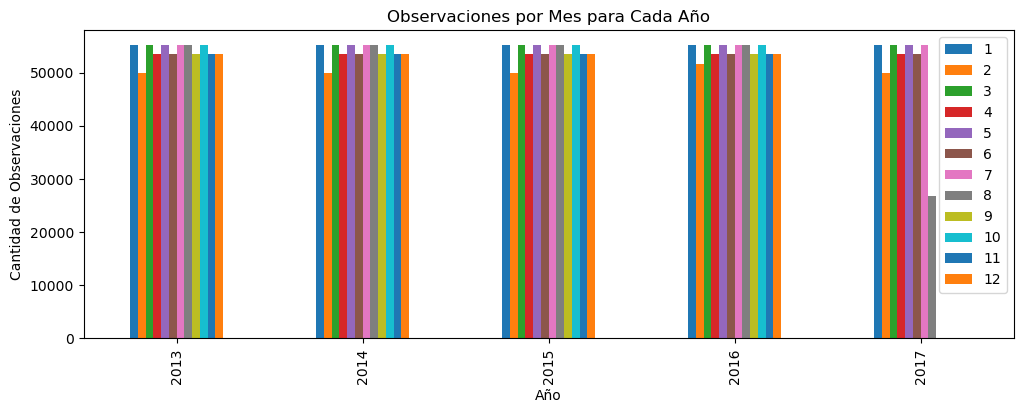

In [104]:
# Mostramos las observaciones por anio
plt.figure(figsize=(5,8))

# Crear el gráfico de barras
datos_por_anio.plot(kind='bar', figsize=(12, 4), title='Observaciones por Mes para Cada Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Observaciones')
plt.legend(loc='best')
plt.show()

Con base en el análisis de la variable date, se determinó que los datos están en una resolución diaria. Aunque se observaron múltiples registros dentro de un mismo día, estos no corresponden a diferentes horas, ya que todos los registros tienen la hora establecida en "0". Esto sugiere que la granularidad temporal del dataset se limita a días completos, con diferentes observaciones dentro de cada día que probablemente representen distintas combinaciones de productos, tiendas o promociones. Por lo tanto, el análisis temporal deberá enfocarse en tendencias y patrones diarios, tales como la evolución de las ventas a lo largo del tiempo y la influencia de factores estacionales o eventos especiales.

#### Variable "store_nbr"

In [110]:
# Vemos los valores unicos de la variable
train_data.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])